# Label touch count and touch portion
In this notebook we explain the concept of touch count and touch portion between labels. The two measurements can be used to characterize label images showing touching objects such as cells in tissues.

In [1]:
import numpy as np
import pyclesperanto_prototype as cle
from skimage.io import imread
import matplotlib.pyplot as plt

## Motivation
We study tissues which are characterized by local and regional relationsships of cells. One method for doing this is to study the contact area between cells in tissues ([Guignard et al 2020](https://www.science.org/doi/10.1126/science.aar5663)). There is a variety of measurements which can be derived from labeled images that the one way or the other described the contact area. Those measurements and ways for visualizing them should be introduced here. As an example, we visualize the touch portion and touch portion asymmetry in an image stack of a Tribolium embryo. The dataset, curtesy of Daniela Vorkel / Myers lab / MPI-CBG / CSBD can be [downloaded here](https://github.com/clEsperanto/clesperanto_example_data/blob/main/Lund-100MB.tif). 

Note that the methods introduced below assume that images have an isotropic voxel size.

In [2]:
embryo = imread("../../../clesperanto_example_data/Lund-100MB.tif")[3]

bg_subtracted = cle.top_hat_box(embryo, radius_x=5, radius_y=5)

nuclei_labels = cle.voronoi_otsu_labeling(bg_subtracted, spot_sigma=0.5, outline_sigma=1)

cell_estimation = cle.dilate_labels(nuclei_labels, radius=12)

In [3]:
touch_mesh = cle.draw_mesh_between_touching_labels(cell_estimation)

touch_centroid_distance_mesh = cle.draw_distance_mesh_between_touching_labels(cell_estimation)

touch_portion_mesh_ = cle.draw_touch_portion_mesh_between_touching_labels(cell_estimation)

touch_portion_ratio_mesh = cle.draw_touch_portion_ratio_mesh_between_touching_labels(cell_estimation)

In [4]:
number_of_touching_neighbors = cle.touching_neighbor_count_map(cell_estimation)

number_of_proximal_neighbors = cle.proximal_neighbor_count_map(cell_estimation, max_distance=25)

average_distance_of_nearest_neighbors = cle.average_distance_of_n_nearest_neighbors_map(cell_estimation, n=6)

standard_deviation_touch_portion_map = cle.standard_deviation_touch_portion_map(cell_estimation)

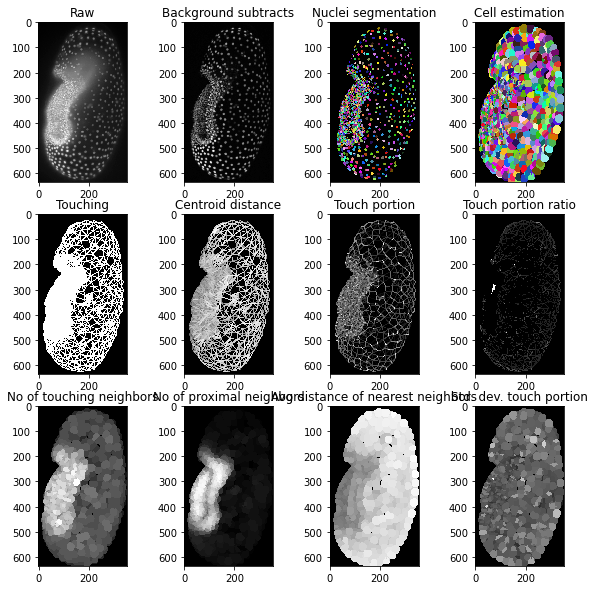

In [5]:
fig, axs = plt.subplots(3, 4, figsize=(10,10))

axs[0,0].set_title("Raw")
cle.imshow(embryo, plot=axs[0,0])
axs[0,1].set_title("Background subtracted")
cle.imshow(bg_subtracted, plot=axs[0,1])
axs[0,2].set_title("Nuclei segmentation")
cle.imshow(nuclei_labels, plot=axs[0,2], labels=True)
axs[0,3].set_title("Cell estimation")
cle.imshow(cell_estimation, plot=axs[0,3], labels=True)

def thicker_lines(mesh):
    return cle.maximum_box(mesh, radius_x=1, radius_y=1)

axs[1,0].set_title("Touching")
cle.imshow(thicker_lines(touch_mesh), plot=axs[1,0])
axs[1,1].set_title("Centroid distance")
cle.imshow(thicker_lines(touch_centroid_distance_mesh), plot=axs[1,1])
axs[1,2].set_title("Touch portion")
cle.imshow(thicker_lines(touch_portion_mesh_), plot=axs[1,2])
axs[1,3].set_title("Touch portion ratio")
cle.imshow(thicker_lines(touch_portion_ratio_mesh), plot=axs[1,3])

axs[2,0].set_title("No of touching neighbors")
cle.imshow(number_of_touching_neighbors, plot=axs[2,0])
axs[2,1].set_title("No of proximal neighbors")
cle.imshow(number_of_proximal_neighbors, plot=axs[2,1])
axs[2,2].set_title("Avg distance of nearest neighbors")
cle.imshow(average_distance_of_nearest_neighbors, plot=axs[2,2])
axs[2,3].set_title("Std. dev. touch portion")
cle.imshow(standard_deviation_touch_portion_map, plot=axs[2,3])

## Demonstration with a simpler example
Our example image shows a couple of objects. In the following, we will concentrate on the objects `4` and `5` in the center of the image.

cl.OCLArray([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint32)
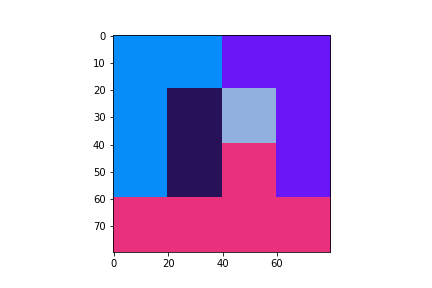

In [6]:
labels = cle.scale(cle.asarray([
   [1, 1, 1, 1, 2, 2, 2, 2],
   [1, 1, 1, 1, 2, 2, 2, 2],
   [1, 1, 4, 4, 5, 5, 2, 2],
   [1, 1, 4, 4, 5, 5, 2, 2],
   [1, 1, 4, 4, 3, 3, 2, 2],
   [1, 1, 4, 4, 3, 3, 2, 2],
   [3, 3, 3, 3, 3, 3, 3, 3],
   [3, 3, 3, 3, 3, 3, 3, 3],
]), factor_x=10, factor_y=10, auto_size=True).astype(np.uint32)
labels

## Touch count
Touch count is a measure of how many pixels along edge of label A touch with label B. This measurement can be expressed in a `touch_count_matrix` which is symmetric: the number of pixels in A which touch B is equal to the number of labels in B which touch A.

In [7]:
touch_count_matrix = cle.generate_touch_count_matrix(labels)
print(touch_count_matrix)

[[ 0  0  0  0  0  0]
 [ 0  0 20 20 60  0]
 [ 0 20  0 40  0 40]
 [ 0 20 40  0 40 20]
 [ 0 60  0 40  0 20]
 [ 0  0 40 20 20  0]]


To demonstrate interpreting this matrix, we use a for-loop to read out measurements relevant for one label:

In [8]:
label_of_interest = 4

for l in range(1,6):
    num_pixels_touching = touch_count_matrix[l, label_of_interest]
    if num_pixels_touching > 0:
        print(f"Label {label_of_interest} touches label {l} in {num_pixels_touching} pixels")

Label 4 touches label 1 in 60 pixels
Label 4 touches label 3 in 40 pixels
Label 4 touches label 5 in 20 pixels


## Touch portion
The touch portion is the ratio of pixels along a label A's border with another label B divided by the total number of pixels along label A's border. 

**Note:** This matrix is not symmetric. The ratio of A versus B depends on if the computation divides the touch count by label A's or B's total number of border pixels.

In [9]:
touch_portion_matrix = cle.generate_touch_portion_matrix(labels)
print(touch_portion_matrix)

[[       nan 0.         0.         0.         0.         0.        ]
 [       nan 0.         0.19999999 0.16666666 0.49999997 0.        ]
 [       nan 0.19999999 0.         0.3333333  0.         0.5       ]
 [       nan 0.19999999 0.39999998 0.         0.3333333  0.25      ]
 [       nan 0.59999996 0.         0.3333333  0.         0.25      ]
 [       nan 0.         0.39999998 0.16666666 0.16666666 0.        ]]


Thus, this matrix must be read out carefully. When reading it like this, the sum of all percentages is 100%:

In [10]:
for l in range(1,6):
    ratio_touching = touch_portion_matrix[l, label_of_interest]
    if ratio_touching > 0:
        print(f"Label label_of_interest touches label {l} in {ratio_touching*100}% of its border")

Label label_of_interest touches label 1 in 49.99999701976776% of its border
Label label_of_interest touches label 3 in 33.33333134651184% of its border
Label label_of_interest touches label 5 in 16.66666567325592% of its border


To demonstrate the asymmetry again, we show the label image once more and then read out the touch portion between 4 and 5, and the touch portion between 5 and 4.

cl.OCLArray([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint32)
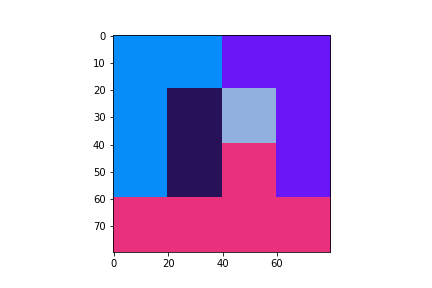

In [11]:
labels

In [12]:
def explain(label_A, label_B):
    print(f"Label {label_A} and label {label_B} touch in {touch_portion_matrix[label_A, label_B]*100}% of label {label_B}'s border.")
    print(f"Label {label_B} and label {label_A} touch in {touch_portion_matrix[label_B, label_A]*100}% of label {label_A}'s border.")

explain(5, 4)

Label 5 and label 4 touch in 16.66666567325592% of label 4's border.
Label 4 and label 5 touch in 25.0% of label 5's border.


## Touch-portion meshes
Taking the example above, we note that for each edge between two labels, two measurements of touch-portion exist. When we draw a mesh between the labels, the average between these two will be visualized. We can validate that by computing the average touch portion of labels 4 and 5.

In [13]:
mean_touch_portion_4_5 = (touch_portion_matrix[4, 5] + touch_portion_matrix[5, 4]) / 2
mean_touch_portion_4_5

0.2083333283662796

In [14]:
ratio_touch_portion_4_5 = max(touch_portion_matrix[4, 5], touch_portion_matrix[5, 4]) / \
                          min(touch_portion_matrix[4, 5], touch_portion_matrix[5, 4])
ratio_touch_portion_4_5

1.5000001

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
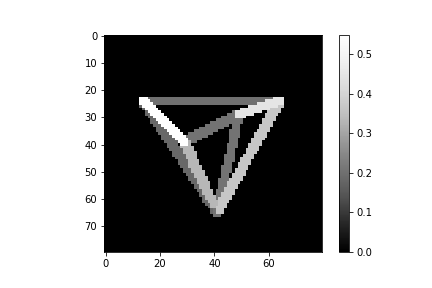
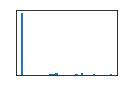

In [15]:
touch_portion_mesh = cle.draw_touch_portion_mesh_between_touching_labels(labels)

# for visualization purposes, we make the lines thicker
mesh_visualized = cle.maximum_box(touch_portion_mesh)
mesh_visualized

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
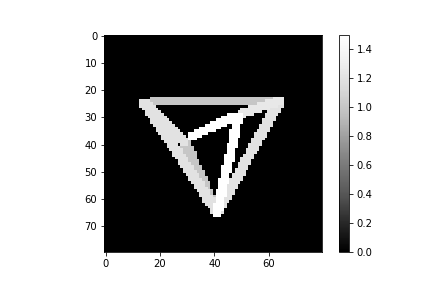
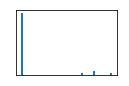

In [16]:
touch_portion_ratio_mesh = cle.draw_touch_portion_ratio_mesh_between_touching_labels(labels)

# for visualization purposes, we make the lines thicker
mesh_visualized = cle.maximum_box(touch_portion_ratio_mesh)
mesh_visualized

In [17]:
# read out edge between 4 and 5
centroids = np.asarray(cle.centroids_of_background_and_labels(labels))

centroid_4 = centroids[:,4]
centroid_5 = centroids[:,5]

# compute center between both centroids in Y-X order:
point_between_4_and_5 = (((centroid_4 + centroid_5) / 2)[::-1]).astype(int)
print("Point between 4 and 5 (Y,X):", point_between_4_and_5)

touch_portion_mesh[point_between_4_and_5[0], point_between_4_and_5[1]]

Point between 4 and 5 (Y,X): [34 39]


array(0.20833333, dtype=float32)

In [18]:
touch_portion_ratio_mesh[point_between_4_and_5[0], point_between_4_and_5[1]]

array(1.5000001, dtype=float32)